In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
import numba
from numba import jit

Laplaces Equation:

$$\nabla^2 V=0$$

everywhere in the square. We are in 2D, so this means

$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=0$$

Taking Taylor expansions of $V$ about the four points $(x_0\pm\delta, y_0)$, $(x_0, y_0\pm\delta)$, and solving simultaneously for $V(x_0,y_0) we obtain the following formula:

$$V(x_0, y_0) = \frac{1}{4}(V(x_0+\delta,y_0) + V(x_0-\delta,y_0) + V(x_0,y_0+\delta) + V(x_0,y_0-\delta))$$

So the idea is that if we repeatedly set

$$V(x_i, y_j) \to \frac{1}{4}(V(x_{i+1}, y_{j}) + V(x_{i-1}, y_{j}) + V(x_{i}, y_{j+1}) + V(x_{i}, y_{j-1}))$$

$V$ will eventually converge to the true solution. Note that our formuala required equally spaced grid points in $x$ and $y$ 

# Boundaries Only

Define the boundary conditions

In [2]:
xEdge = np.arange(0,50.1,.1)
yEdge = np.arange(0,10.1,.1)
upper_y = 0*xEdge
lower_y = 0*xEdge
upper_x = 0*yEdge
lower_x = np.sin(3*np.pi*yEdge/10)


Get a meshgrid

In [3]:
xv, yv = np.meshgrid(xEdge, yEdge)
np.shape(xv)

(101, 501)

Define function to solve for the potential

In [4]:
@numba.jit("f8[:,:](f8[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential, n_iter):
    lx = len(potential[0,:])
    ly = len(potential[:,0])
    for n in range(n_iter):
        for i in range(1, lx-1):
            for j in range(1, ly-1):
                potential[j][i] = 1/4 * (potential[j+1][i] + potential[j-1][i] + potential[j][i+1] + potential[j][i-1])
    return potential

Solve for potential

In [5]:
potential = np.random.rand(np.shape(xv)[0], np.shape(xv)[1])
potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x

potential = compute_potential(potential, n_iter=10000)

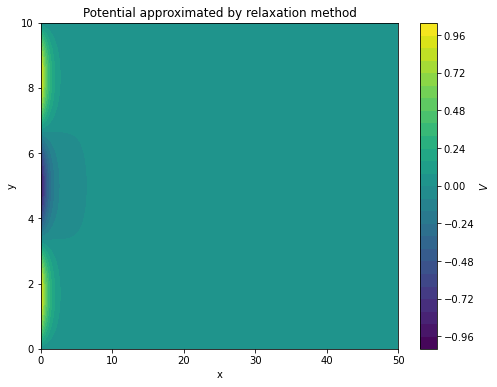

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(clr_plot, label='$V$')
ax.set_title('Potential approximated by relaxation method')
plt.show()

# Exact Solution

The exact solution to this BVP is given by:

$$ V(x,y) = e^{-3\pi x/10}sin\left(\frac{3\pi}{10}y\right) $$

(We simplified the boundary condition at $x=50$ by instead requiring $V(x,y) \rightarrow 0$ as $x \rightarrow \infty$)

Defining our potential function

In [7]:
def Z(x,y):
    return np.exp(-3*np.pi*x/10)*np.sin(3*np.pi*y/10)


Plotting for our region of interest

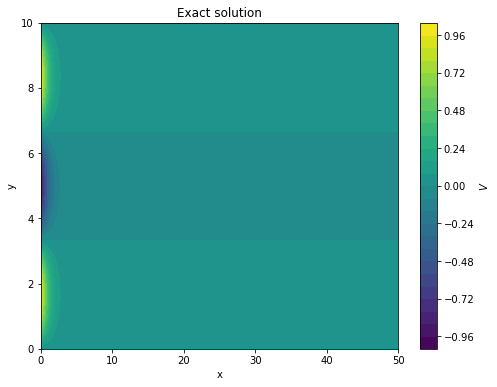

In [8]:
V_true = Z(xv,yv)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
clr_plot = ax.contourf(xv, yv, V_true, 30)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(clr_plot, label='$V$')
ax.set_title('Exact solution')
plt.show()

# With a Block of Fixed Potential

Define a block which is set at a constant potential of $V=1$, located at $20<x<22$, $4<y<6$

In [9]:
def potential_block(x, y):
    return np.select([(x>20)*(x<22)*(y>4)*(y<6),
                      (x<=20)+(x>=22)+(y<=4)+(y>=6)],
                     [1.,
                      0])

Show the location of the fixed potential

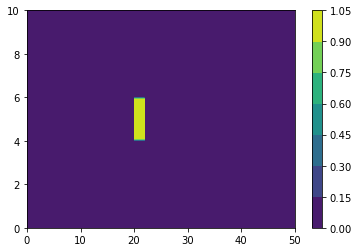

In [10]:
plt.figure()
plt.contourf(xv, yv, potential_block(xv,yv))
plt.colorbar()

Obtain the fixed potential, and the places where the potential is fixed

In [11]:
fixed = potential_block(xv,yv)
fixed_bool = fixed!=0

Modify the compute potential function so it doesn't set the modify the points at the fixed potential during the relaxation procedure

In [12]:
@numba.jit("f8[:,:](f8[:,:], b1[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential, fixed_bool, n_iter):
    lx = len(potential[0,:])
    ly = len(potential[:,0])
    for n in range(n_iter):
        for i in range(1, lx-1):
            for j in range(1, ly-1):
                if not(fixed_bool[j][i]):
                    potential[j][i] = 1/4 * (potential[j+1][i] + potential[j-1][i] + potential[j][i+1] + potential[j][i-1])
    return potential

Solve for the potential

In [16]:
potential = np.zeros(np.shape(xv))
potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x

potential[fixed_bool] = fixed[fixed_bool]
potential = compute_potential(potential, fixed_bool, n_iter=10000)

Plot

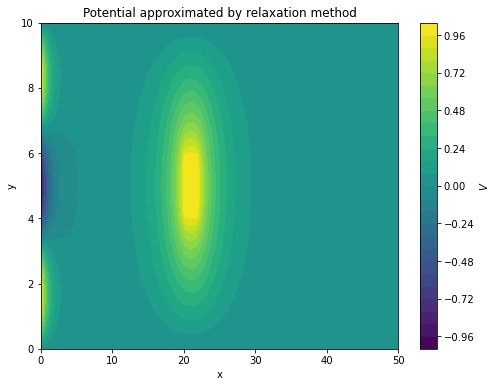

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(clr_plot, label='$V$')
ax.set_title('Potential approximated by relaxation method')
plt.show()